# Masking PX 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import input_power
import silicon
import skewer_maker

Define the input power spectrum

In [3]:
input_p=input_power.InputPower(P0=10.0,k0=0.01,kF=0.1,f_px=0.7)

Level of SiIII(1207) contamination

In [4]:
SiIII_model=silicon.SiliconModel(r_SiIII=2271,a_SiIII=0.05)

Define the long FFT grid used to generate skewers

In [5]:
seed=1234
# whole range of FFT grid (larger than the length of a given skewer)
L_long=80000
N_long=2**11
dx_long=L_long/N_long
print('long',N_long,L_long,dx_long)
maker=skewer_maker.SkewerMaker(N=N_long,L=L_long,input_power=input_p,SiIII_model=SiIII_model,seed=seed)

long 2048 80000 39.0625


Define the survey window (skewers will only be visible here)

In [6]:
N_window=N_long//8
L_window=L_long*N_window/N_long
print('window',N_window,L_window,L_window/N_window)

window 256 10000.0 39.0625


In [7]:
# the FFT grid used in the analysis could be different than the window, since we might add zero padding
N=int(2*N_window)
L=L_window*N/N_window
# pixel width 
dx = L/N
print('analysis',N,L,dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.fftfreq(N)*2*np.pi/dx
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',-k[N//2],np.pi/dx)
# Positions
x = dx*np.arange(N)

analysis 512 20000.0 39.0625
Delta k = 0.0003141592653589793 0.0003141592653589793
k_Ny =  0.0804247719318987 0.0804247719318987


In [8]:
# evaluate input P1D and PX in the analysis grid 
true_p1d=input_p.get_true_p1d(np.abs(k))
true_px=input_p.get_true_px(np.abs(k))
if SiIII_model:
    true_p1d *= SiIII_model.power_contamination(k)
    true_px *= SiIII_model.power_contamination(k)

### Analyse multiple (pairs of) skewers

In [9]:
# number of pairs of skewers to make
Np=int(1e5)
savedir='px_{}_{}_{}_L{}_{}/'.format(N_long,N_window,N,int(L),Np)
if os.path.isdir(savedir):
    print(savedir,'already exists, will override')
else:
    print('make new directory',savedir)
    os.mkdir(savedir)

px_2048_256_512_L20000_100000/ already exists, will override


In [10]:
# reset seed again
maker.reset_seed()
# measure P1D and PX and their variance ( F_m = < |f_m|^2 >)
F_m=np.zeros([2,N])
var_F_m=np.zeros([2,N])
# mean of |w_m|^2 (FFT of mask, squared)
# for PX this is (w_m v_m^*).real (product of FFT mask, real part only)
w2_m=np.zeros([2,N])
for i in tqdm(range(Np)):
    # each quasar will have a different redshift (starting point of window)
    i_1=np.random.randint(low=0, high=N-N_window)
    i_2=np.random.randint(low=0, high=N-N_window)
    # create masks for this particular pair
    mask_1=np.zeros(N)
    mask_1[i_1:i_1+N_window]=1
    mask_2=np.zeros(N)
    mask_2[i_2:i_2+N_window]=1    
    # FFT of masks
    w_1_m = np.fft.fft(mask_1)
    w_2_m = np.fft.fft(mask_2)
    w2_m[0] += 0.5*(abs(w_1_m)**2+abs(w_2_m)**2)
    w2_m[1] += (w_1_m*np.conjugate(w_2_m)).real
    # generate random field 
    skewer_1,skewer_2=maker.make_skewer_pair()
    # keep only those within window, in the FFT grid
    deltas_1 = skewer_1[:N]
    deltas_1 *= mask_1
    deltas_2 = skewer_2[:N]
    deltas_2 *= mask_2   
    # and FFT again to obtain masked modes
    f_1_m=np.fft.fft(deltas_1)
    f_2_m=np.fft.fft(deltas_2)
    p1d = 0.5*(abs(f_1_m)**2+abs(f_2_m)**2)   
    px = (f_1_m*np.conjugate(f_2_m)).real
    F_m[0] += p1d
    F_m[1] += px
    var_F_m[0] += p1d**2
    var_F_m[1] += px**2
# normalize mask
w2_m /= Np
# normalize them
F_m /= Np
var_F_m /= Np
var_F_m -= F_m**2
# correct normalisation based on my notes
mean_p1d = (dx/N) * F_m[0]
mean_px = (dx/N) * F_m[1]
err_p1d = (dx/N) * np.sqrt(var_F_m[0]/Np)
err_px = (dx/N) * np.sqrt(var_F_m[1]/Np)

100%|█████████████████████████████████| 100000/100000 [00:17<00:00, 5880.18it/s]


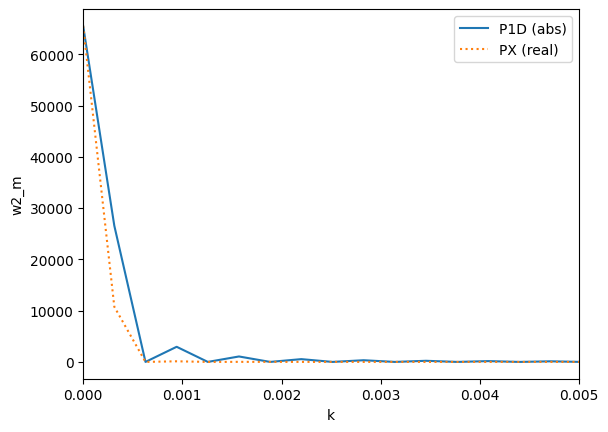

In [11]:
# plot FFT of mask (squared)
plt.plot(k[:N//2],w2_m[0,:N//2],label='P1D (abs)')
plt.plot(k[:N//2],w2_m[1,:N//2],ls=':',label='PX (real)')
plt.legend()
plt.xlabel('k')
plt.ylabel('w2_m')
plt.xlim([0,0.005])
plt.savefig(savedir+'/w2_m.pdf')

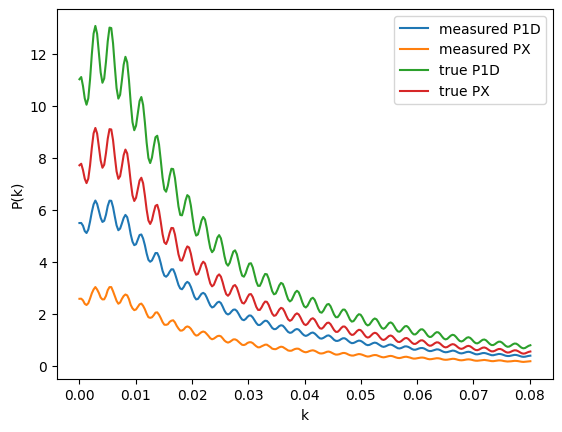

In [12]:
plt.plot(k[:N//2],mean_p1d[:N//2],label='measured P1D')
plt.plot(k[:N//2],mean_px[:N//2],label='measured PX')
plt.plot(k[:N//2],true_p1d[:N//2],label='true P1D')
plt.plot(k[:N//2],true_px[:N//2],label='true PX')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.savefig(savedir+'/p1d_px.pdf')

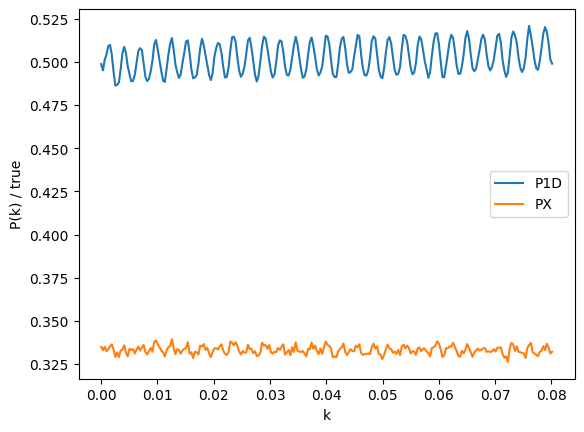

In [13]:
plt.plot(k[:N//2],mean_p1d[:N//2]/true_p1d[:N//2],label='P1D')
plt.plot(k[:N//2],mean_px[:N//2]/true_px[:N//2],label='PX')
plt.xlabel('k')
plt.ylabel('P(k) / true')
plt.legend()
plt.savefig(savedir+'/p1d_px_ratio.pdf')

### Try to convolve theory with mask

In [14]:
# use iFFT of P1D evaluated on the grid
P_m = np.empty([2,N])
P_m[0] = true_p1d / dx # < |delta_m|^2 >
P_m[1] = true_px / dx
xi_a = np.empty([2,N])
xi_a[0] = np.fft.ifft(P_m[0]).real
xi_a[1] = np.fft.ifft(P_m[1]).real
Q_a = np.empty([2,N])
Q_a[0] = np.fft.ifft(w2_m[0]).real
Q_a[1] = np.fft.ifft(w2_m[1]).real

In [15]:
T_m = np.empty([2,N])
T_m[0] = np.fft.fft(Q_a[0]*xi_a[0]).real
T_m[1] = np.fft.fft(Q_a[1]*xi_a[1]).real

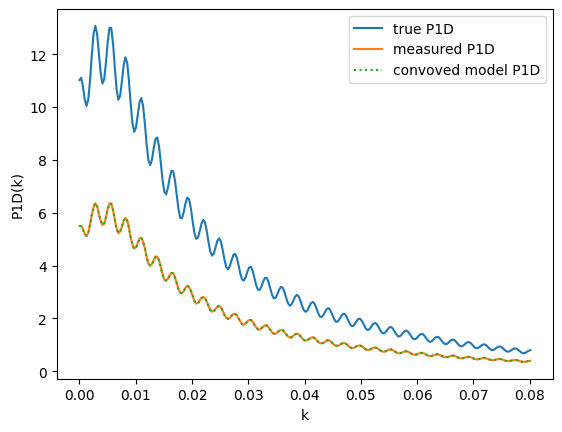

In [16]:
plt.plot(k[:N//2],true_p1d[:N//2],label='true P1D')
plt.plot(k[:N//2],mean_p1d[:N//2],label='measured P1D')
#plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k[:N//2],T_m[0,:N//2].real*(dx/N),ls=':',label='convoved model P1D')
plt.xlabel('k')
plt.ylabel('P1D(k)')
plt.legend()
plt.savefig(savedir+'/p1d_convolved.pdf')

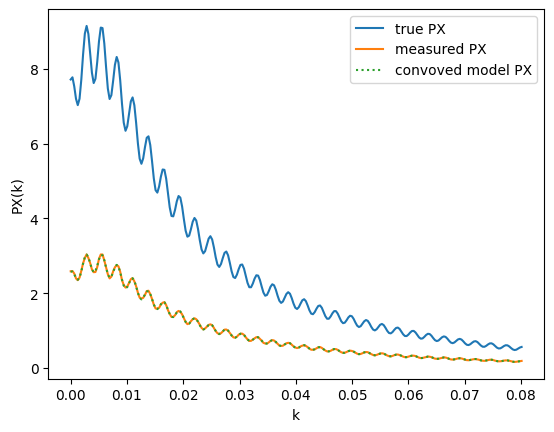

In [17]:
plt.plot(k[:N//2],true_px[:N//2],label='true PX')
plt.plot(k[:N//2],mean_px[:N//2],label='measured PX')
#plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k[:N//2],T_m[1,:N//2].real*(dx/N),ls=':',label='convoved model PX')
plt.xlabel('k')
plt.ylabel('PX(k)')
plt.legend()
plt.savefig(savedir+'/px_convolved.pdf')

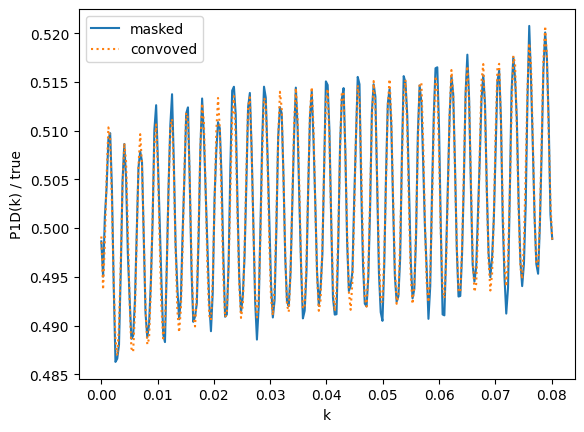

In [18]:
plt.plot(k[:N//2],mean_p1d[:N//2]/true_p1d[:N//2],label='masked')
plt.plot(k[:N//2],T_m[0,:N//2].real*(dx/N)/true_p1d[:N//2],ls=':',label='convoved')
plt.xlabel('k')
plt.ylabel('P1D(k) / true')
plt.legend()
plt.savefig(savedir+'/p1d_ratio_convolved.pdf')

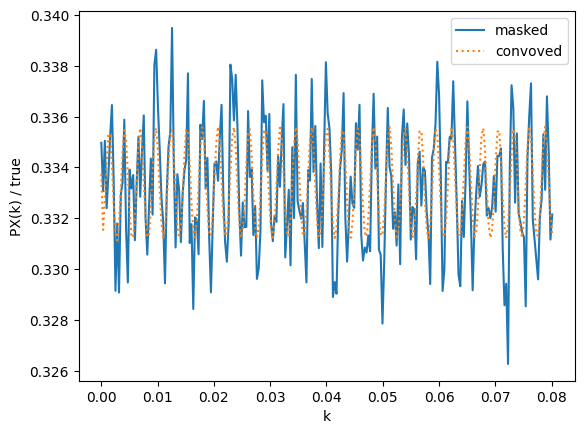

In [19]:
plt.plot(k[:N//2],mean_px[:N//2]/true_px[:N//2],label='masked')
plt.plot(k[:N//2],T_m[1,:N//2].real*(dx/N)/true_px[:N//2],ls=':',label='convoved')
plt.xlabel('k')
plt.ylabel('PX(k) / true')
plt.legend()
plt.savefig(savedir+'/px_ratio_convolved.pdf')

(-0.0001, 0.005)

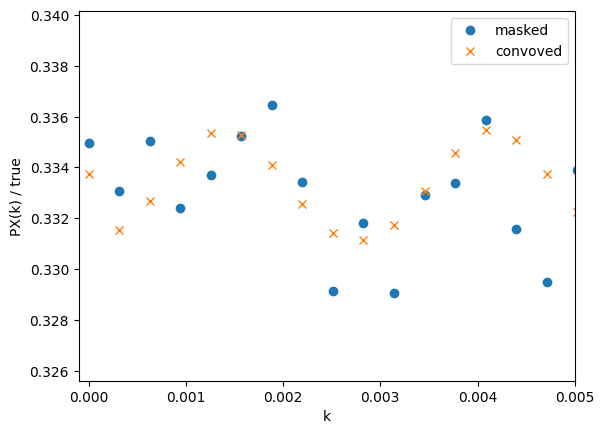

In [20]:
plt.plot(k[:N//2],mean_px[:N//2]/true_px[:N//2],'o',label='masked')
plt.plot(k[:N//2],T_m[1,:N//2].real*(dx/N)/true_px[:N//2],'x',label='convoved')
plt.xlabel('k')
plt.ylabel('PX(k) / true')
plt.legend()
plt.xlim([-0.0001,0.005])
#plt.savefig(savedir+'/px_ratio_convolved.pdf')

### Rebin power

In [21]:
# we will use band powers defined by the grid of the forest (L/4)
dk_bin=2*np.pi/L_window
print('dk =',dk_bin)
# stop roughly at half the Nyquist frequency for now
k_max=np.pi/dx/2
print('k < ',k_max)
k_edges=np.arange(0.01*dk_bin,k_max+dk_bin,dk_bin)
Nk=k_edges.size-1
print('Nk =',Nk)

dk = 0.0006283185307179586
k <  0.04021238596594935
Nk = 64


In [22]:
# define the rebinning vector B_alpha_m in the notes (including negative frequencies!)
B_m=np.zeros([Nk,N])
for i in range(Nk):
    #print(i,k_edges[i],k_edges[i+1])
    inbin=(abs(k)>k_edges[i]) & (abs(k)<k_edges[i+1])
    B_m[i,inbin]=1    

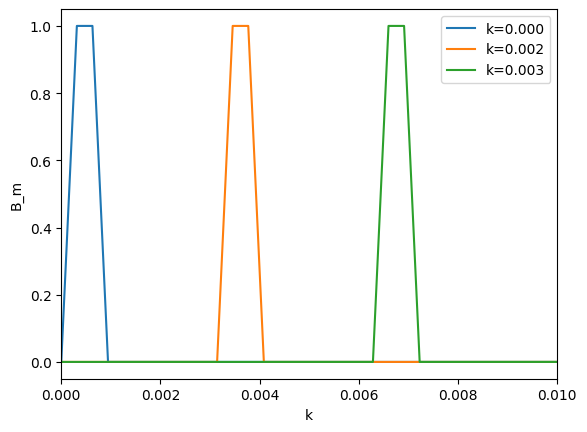

In [23]:
plt.plot(k[:N//2],B_m[0][:N//2],label='k={:.3f}'.format(k[0]))
plt.plot(k[:N//2],B_m[5][:N//2],label='k={:.3f}'.format(k[5]))
plt.plot(k[:N//2],B_m[10][:N//2],label='k={:.3f}'.format(k[10]))
plt.legend()
plt.xlim([0,0.01])
plt.xlabel('k')
plt.ylabel('B_m')
plt.savefig(savedir+'B_m.pdf')

In [24]:
# iFFT B_m to get B_a (for the convolution theorem)
B_a=np.empty([Nk,N])
for i in range(Nk):
    B_a[i]=np.fft.ifft(B_m[i]).real

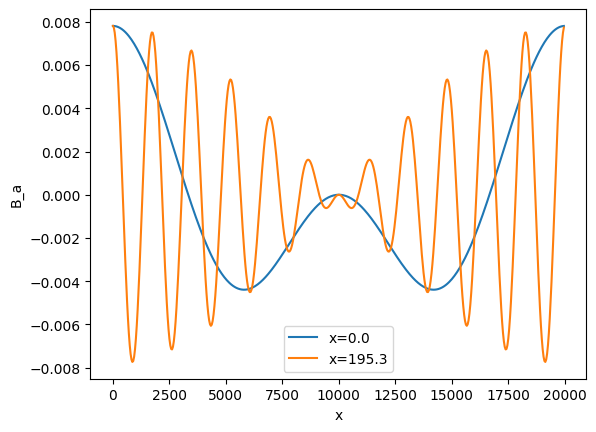

In [25]:
plt.plot(x,B_a[0],label='x={:.1f}'.format(x[0]))
plt.plot(x,B_a[5],label='x={:.1f}'.format(x[5]))
#plt.plot(x,B_a[10],label='x={:.1f}'.format(x[10]))
plt.xlabel('x')
plt.ylabel('B_a')
plt.legend()
plt.savefig(savedir+'B_a.pdf')

In [26]:
BQ_m=np.empty([2,Nk,N])
for i in range(Nk):
    BQ_m[0,i]=np.fft.fft(B_a[i]*Q_a[0]).real
    BQ_m[1,i]=np.fft.fft(B_a[i]*Q_a[1]).real

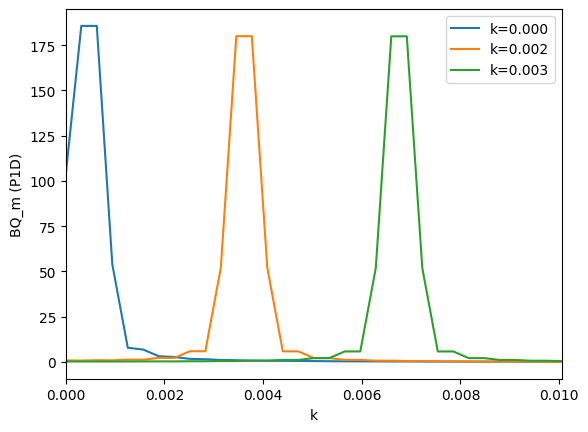

In [27]:
plt.plot(k[:N//2],BQ_m[0,0,:N//2],label='k={:.3f}'.format(k[0]))
plt.plot(k[:N//2],BQ_m[0,5,:N//2],label='k={:.3f}'.format(k[5]))
plt.plot(k[:N//2],BQ_m[0,10,:N//2],label='k={:.3f}'.format(k[10]))
plt.xlim([0,k_max/4])
plt.xlabel('k')
plt.ylabel('BQ_m (P1D)')
plt.legend()
plt.savefig(savedir+'/BQ_p1d_m.pdf')

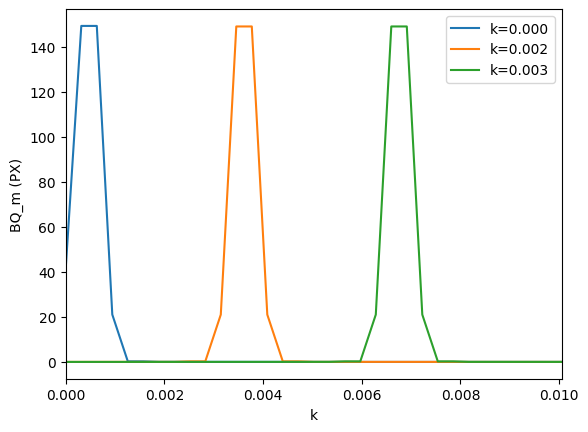

In [28]:
plt.plot(k[:N//2],BQ_m[1,0,:N//2],label='k={:.3f}'.format(k[0]))
plt.plot(k[:N//2],BQ_m[1,5,:N//2],label='k={:.3f}'.format(k[5]))
plt.plot(k[:N//2],BQ_m[1,10,:N//2],label='k={:.3f}'.format(k[10]))
plt.xlim([0,k_max/4])
plt.xlabel('k')
plt.ylabel('BQ_m (PX)')
plt.legend()
plt.savefig(savedir+'/BQ_px_m.pdf')

In [29]:
# normalisation (for this example, this is a constant)
A_A=np.empty([2,Nk])
# mean k in bin A
k_A=np.zeros(Nk)
for i in range(Nk):
    A_A[0,i]=np.sum(BQ_m[0,i])/dx
    A_A[1,i]=np.sum(BQ_m[1,i])/dx    
    k_A[i]=np.sum(B_m[i]*abs(k))/np.sum(B_m[i])

In [30]:
# actual summary statistics
Theta_A=np.zeros([2,Nk])
# convolved model
model_A=np.zeros([2,Nk])
for i in range(Nk):
    Theta_A[0,i]=np.sum(B_m[i]*F_m[0])/A_A[0,i]
    Theta_A[1,i]=np.sum(B_m[i]*F_m[1])/A_A[1,i]
    model_A[0,i]=(np.sum(B_m[i]*T_m[0])/A_A[0,i])
    model_A[1,i]=(np.sum(B_m[i]*T_m[1])/A_A[1,i])

In [31]:
true_p1d_A=input_p.get_true_p1d(k_A)
true_px_A=input_p.get_true_px(k_A)
if SiIII_model:
    true_p1d_A *= SiIII_model.power_contamination(k_A)
    true_px_A *= SiIII_model.power_contamination(k_A)

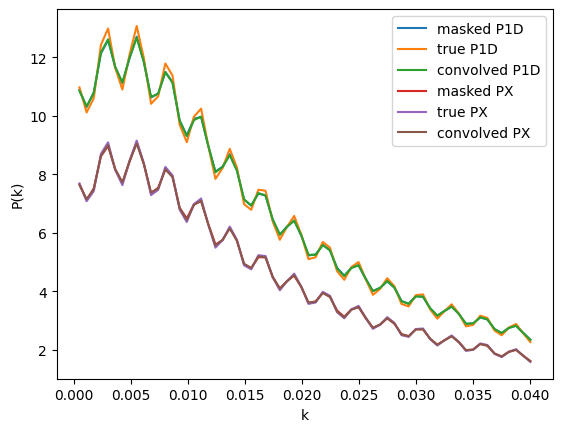

In [32]:
plt.plot(k_A,Theta_A[0],label='masked P1D')
plt.plot(k_A,true_p1d_A,label='true P1D')
plt.plot(k_A,model_A[0],label='convolved P1D')
plt.plot(k_A,Theta_A[1],label='masked PX')
plt.plot(k_A,true_px_A,label='true PX')
plt.plot(k_A,model_A[1],label='convolved PX')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.savefig(savedir+'binned_p1d_px_convolved.pdf')

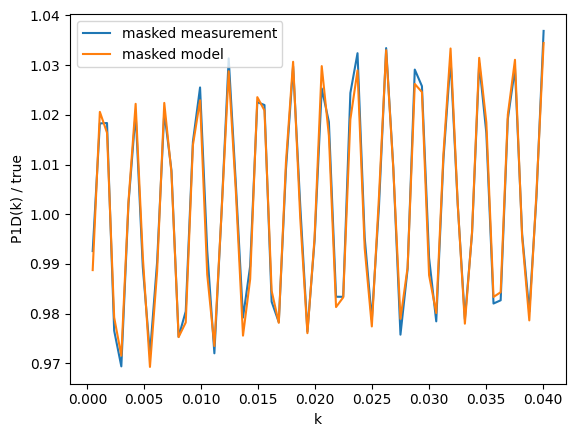

In [33]:
plt.plot(k_A,Theta_A[0]/true_p1d_A,label='masked measurement')
plt.plot(k_A,model_A[0]/true_p1d_A,label='masked model')
plt.xlabel('k')
plt.ylabel('P1D(k) / true')
plt.legend()
plt.savefig(savedir+'binned_p1d_ratio_convolved.pdf')

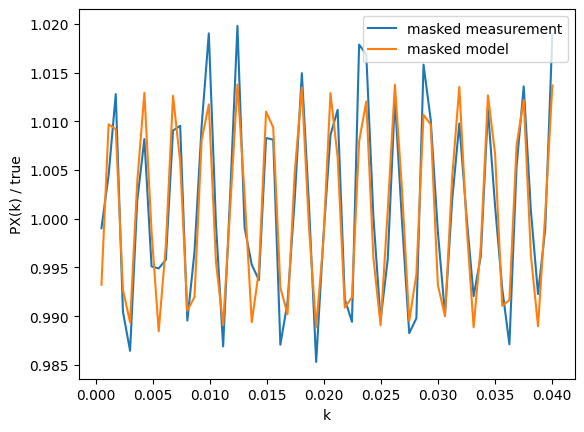

In [34]:
plt.plot(k_A,Theta_A[1]/true_px_A,label='masked measurement')
plt.plot(k_A,model_A[1]/true_px_A,label='masked model')
plt.xlabel('k')
plt.ylabel('PX(k) / true')
plt.legend()
plt.savefig(savedir+'binned_px_ratio_convolved.pdf')